# Imports

In [1]:
import pandas as pd
import numpy as np
import random
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

%matplotlib inline

# Read in and view dataset

In [2]:
wine = pd.read_csv('../../datasets/winequalityN.csv') #read in the dataset

wine.head() #view the first 5 rows

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


# Understand the data

In [3]:
wine.describe() #see the summary statistics of the numerical data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [4]:
wine.info() #get info on what type of data is in each column as well as how many non null values each one contains

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
type                    6497 non-null object
fixed acidity           6487 non-null float64
volatile acidity        6489 non-null float64
citric acid             6494 non-null float64
residual sugar          6495 non-null float64
chlorides               6495 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6488 non-null float64
sulphates               6493 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 659.9+ KB


In [5]:
wine.isna().sum() # how many null values does each column contain

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

# Some quick exploratory analysis

We can see from the plot below that there is a large class imbalance between the red and white class. This could lead to issues with our models predicting the wrong class more often if trained on this data. We may explore evening out this class inbalance later on in the notebook after we see how our models perform without any class manipulation.

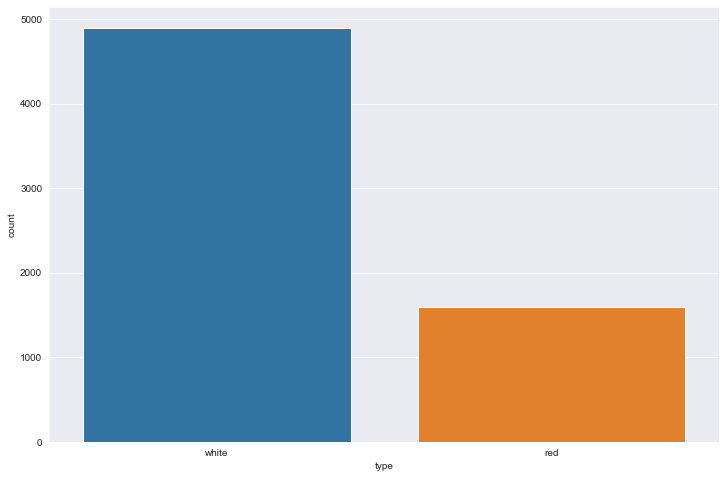

In [6]:
plt.figure(figsize=(12,8))
sns.countplot(wine['type']) # count the number of each class

The data appears to have a very large variation and has may outliers according to the boxplot. However, keep in mind that the graph below is univariate and so what may appear like an outlier here may suddenly not become an outlier when combined with other data.

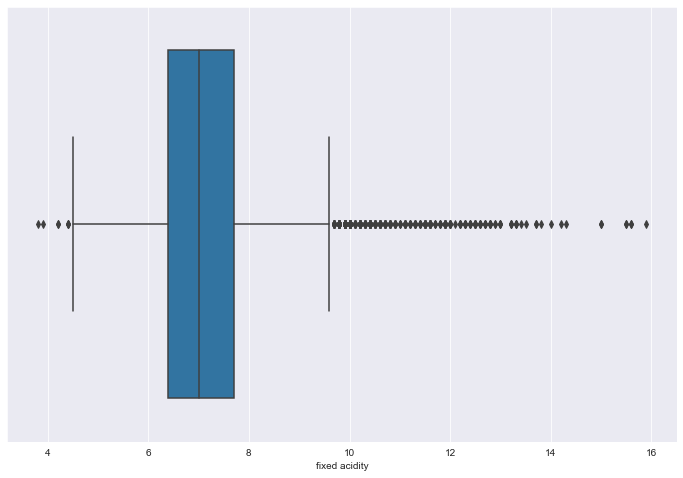

In [7]:
plt.figure(figsize=(12,8))
sns.boxplot(wine['fixed acidity']) #boxplot of the values of the 'fixed acidity' column

Exploring the distribution of the citric acid variable.

(0, 1.825820611814295)

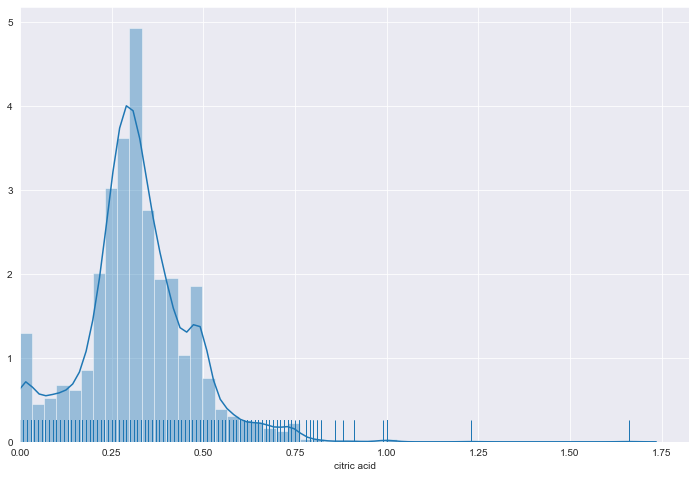

In [8]:
plt.figure(figsize=(12,8))
sns.distplot(wine['citric acid'].dropna(), rug = True) # plot the distribution as well as rugs for each data point
plt.xlim(0) # set the limit of the x axis to start at 0

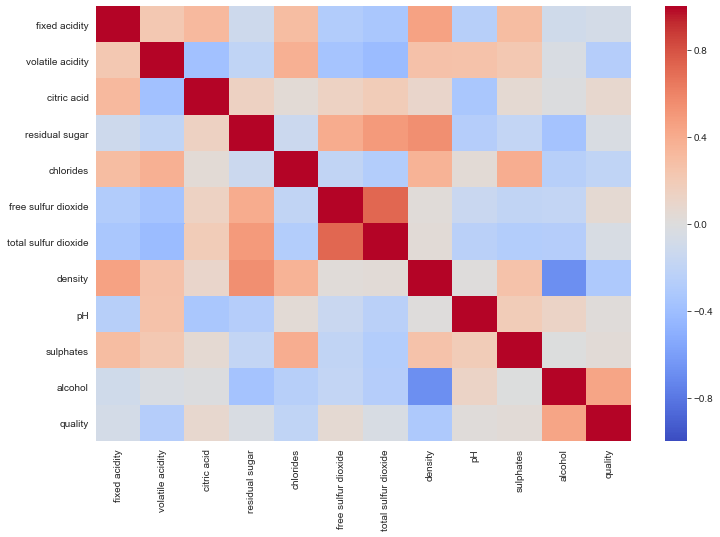

In [9]:
plt.figure(figsize=(12,8))
sns.heatmap(wine.corr(), vmax = 1, vmin = -1, cmap = 'coolwarm') # heatmap

The graph below shows all possible pairs of variables plotted against each other. Therefore it can be seen that there are not as many outliers as one may have originally thought by looking at the boxplot above.

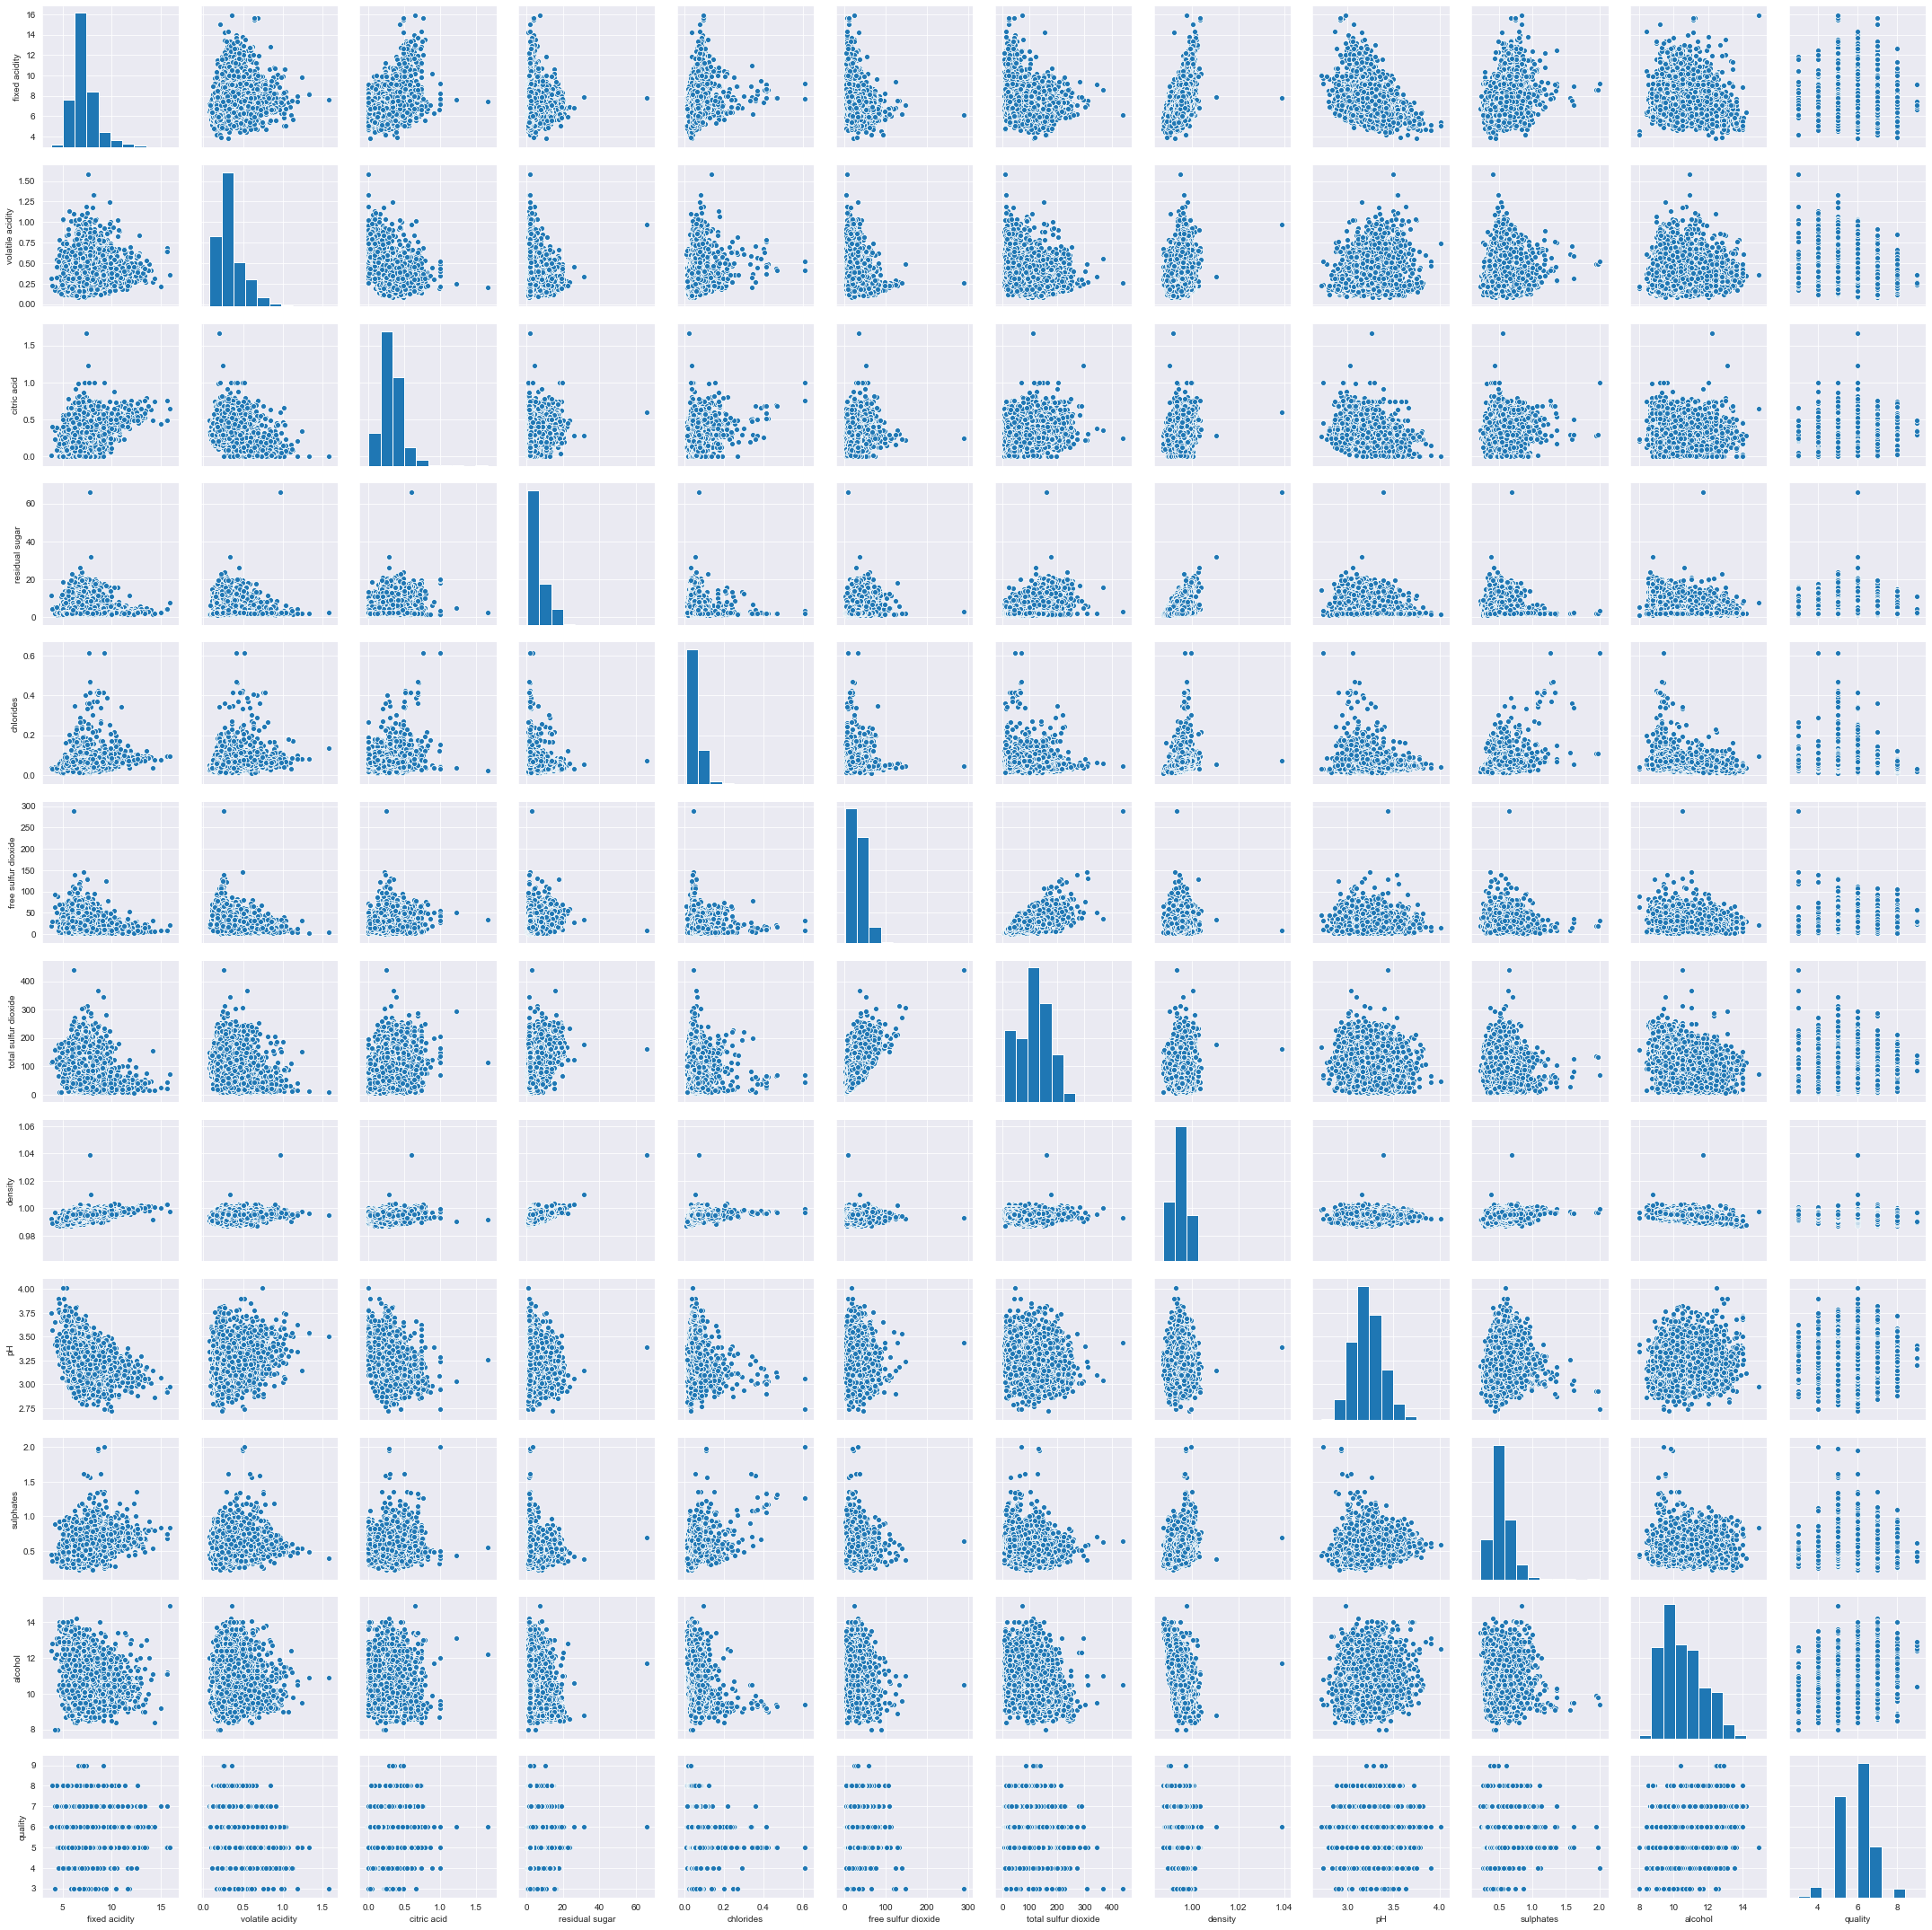

In [10]:
sns.pairplot(wine.dropna().drop('type', axis = 1)) # plot of all pairs of variables in the dataset

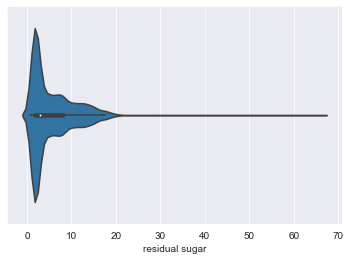

In [11]:
sns.violinplot(wine['residual sugar']) # violin plot, similar to boxplot but also shows density

In [12]:
class impute_from_distribution(BaseEstimator, TransformerMixin): # inherit from sklearn.base classes to create own pipeline function
    def __init__(self, col):
        self.col = col
        self.target_col = 'type' # automatically set the target column to 'target'
    def fit(self, X, y = None):

        _ , self.white_dist = np.histogram(X[(X[self.target_col] == 'white')][self.col].dropna(), bins = 75) # data into 75 bins
        _ , self.red_dist = np.histogram(X[(X[self.target_col] == 'red')][self.col].dropna(), bins = 75) # data into 75 bins

        X[self.col] = X[[self.col, self.target_col]].apply(self._impute, axis = 1) # impute the missing values

        return X

    def transform(self, X, y = None): # transform data
        return X

    def fit_transform(self, X, y = None): # run fit and transform
        X = self.fit(X)
        return self.transform(X)

    def _impute(self, data):
        value = data[0] # the value to be imputed
        type_ = data[1] # the class
        if np.isnan(value): # if the value is NaN
            if type_ == 'white': # if class is 'white'
                return np.quantile(self.white_dist, random.uniform(0,1)) # inverse CDF sampling
            else:
                return np.quantile(self.red_dist, random.uniform(0,1)) # inverse CDF sampling
        else:
            return value # if not NaN return the sample value

In order to write own own imputer for an sklearn pipeline, we created a class that inherits from BaseEstimator and TransormerMixin. This class looks at each record and it's type and if it is NaN, randomly draws a value from the empirical distribution of that variable for the type of wine it is.

In [13]:
def wine_preprocessing(data): # create a pipline function for the wine dataset

    wine_pipeline = Pipeline([('fixed_acidity', impute_from_distribution('fixed acidity')), # run custom function on each column
                                ('volatile_acidity', impute_from_distribution('volatile acidity')), # containing a missing value
                                ('citric_acid', impute_from_distribution('citric acid')),
                                ('residual_sugar', impute_from_distribution('residual sugar')),
                                ('chlorides', impute_from_distribution('chlorides')),
                                ('pH', impute_from_distribution('pH')),
                                ('sulphates', impute_from_distribution('sulphates'))])

    wine = wine_pipeline.fit_transform(data) # fit and transform the data

    data['type'] = data['type'].map({'white': 1, 'red': 0}) # make the classes numerical so it can be handled by sklearn algorithms

    scaler = MinMaxScaler() # scale the data
    wine_scaled = scaler.fit_transform(data.drop('type', axis = 1), data['type']) # fit and transform the data by the fitted scalar

    feat_cols = list(data.columns)
    feat_cols.remove('type')
    data[feat_cols] = wine_scaled # redefine with scaled columns

    return data

In [14]:
wine = wine_preprocessing(wine) # process the dataset
wine.head() # view the first 5 rows of the new dataset

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,0.264463,0.126667,0.216867,0.308282,0.059801,0.152778,0.377880,0.267785,0.217054,0.129213,0.115942,0.5
1,1,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.290323,0.132832,0.449612,0.151685,0.217391,0.5
2,1,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.209677,0.154039,0.418605,0.123596,0.304348,0.5
3,1,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362,0.5
4,1,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362,0.5


In [45]:
X_train, X_test, y_train, y_test = train_test_split(wine.drop('type', axis = 1), wine['type'], test_size=0.33, random_state = 42) # split the dataset

In [46]:
svc = SVC(gamma='scale') # define each of the classifiers
log = LogisticRegression(solver='lbfgs')
rf = RandomForestClassifier()
KNN = KNeighborsClassifier()

Here we are running GridSearchCV to find the best hyperparameters for each of our models to ensure that they perform the best that they can with the options we have given them, especially as we have a large class imbalance.

In [47]:
svc_gs = GridSearchCV(svc, {'C':[0.01,0.1,1,10,30,50,100], 'kernel':['rbf', 'sigmoid']}, cv=5) # define hyper parameters to be tested to maximise results
log_gs = GridSearchCV(log, {'C':[0.01,0.1,1,10,30,50,100]}, cv=5)
rf_gs = GridSearchCV(rf, {'n_estimators':[5, 10, 20,30,50,100]}, cv=5)
KNN_gs = GridSearchCV(KNN, {'n_neighbors':[3,5,7,10,15,25,30,40]}, cv=5)

In [48]:
svc_pred = svc_gs.fit(X_train, y_train).predict(X_test) # fit the models and predict off of them
log_pred = log_gs.fit(X_train, y_train).predict(X_test)
rf_pred = rf_gs.fit(X_train, y_train).predict(X_test)
KNN_pred = KNN_gs.fit(X_train, y_train).predict(X_test)

In [49]:
print('SVC acc: ', accuracy_score(y_test,svc_pred)) # see the accuracy scores
print('Log acc: ', accuracy_score(y_test, log_pred))
print('RF acc: ', accuracy_score(y_test, rf_pred))
print('KNN acc: ', accuracy_score(y_test, KNN_pred))

SVC acc:  0.9962703962703963
Log acc:  0.9897435897435898
RF acc:  0.9934731934731935
KNN acc:  0.9906759906759907


Although these results look promising, do not forget that we had a very significant class imbalance which could have affected our model. Lets look at the classification report and confusion matrix for each of the models.

In [50]:
print(classification_report(y_test,svc_pred)) #SVC
print(confusion_matrix(y_test,svc_pred)) # see the classification report and confusion matrix

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       521
           1       1.00      1.00      1.00      1624

    accuracy                           1.00      2145
   macro avg       1.00      0.99      0.99      2145
weighted avg       1.00      1.00      1.00      2145

[[ 514    7]
 [   1 1623]]


In [51]:
print(classification_report(y_test, log_pred)) #LogisticRegression
print(confusion_matrix(y_test, log_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       521
           1       0.99      0.99      0.99      1624

    accuracy                           0.99      2145
   macro avg       0.99      0.99      0.99      2145
weighted avg       0.99      0.99      0.99      2145

[[ 510   11]
 [  11 1613]]


In [52]:
print(classification_report(y_test, rf_pred)) #RandomForest
print(confusion_matrix(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       521
           1       0.99      1.00      1.00      1624

    accuracy                           0.99      2145
   macro avg       0.99      0.99      0.99      2145
weighted avg       0.99      0.99      0.99      2145

[[ 511   10]
 [   4 1620]]


In [53]:
print(classification_report(y_test, KNN_pred)) #KNN
print(confusion_matrix(y_test, KNN_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       521
           1       1.00      0.99      0.99      1624

    accuracy                           0.99      2145
   macro avg       0.99      0.99      0.99      2145
weighted avg       0.99      0.99      0.99      2145

[[ 513    8]
 [  12 1612]]


All models still appear to be very good at predicting both classes but there is still some imbalance in the scores, it is noticible that class 0 (red) always has slightly lower scores in the classification report which would indicate that the dataset has had some influence on each of the models. However, in this case the models still perform well even with the different metrics in the classification report.

Following is one possible reason the classifiers still performed quite well.

In [54]:
log_gs.best_estimator_ # see what parameters the best estimator had from running GridSearchCV

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
svc_gs.best_estimator_

SVC(C=30, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

The two most accurate classifiers have a large C value, this means that they penalize wrong classifications more during the training process and hence are 'persuaded' not to always predict the larger class. Below is an example of fitting our models without tuning the hyper parameters.

In [56]:
l = LogisticRegression().fit(X_train, y_train)
p = l.predict(X_test)
print(classification_report(y_test, p))
print(confusion_matrix(y_test, p))
print(accuracy_score(y_test, p))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       521
           1       0.98      0.99      0.99      1624

    accuracy                           0.98      2145
   macro avg       0.98      0.97      0.97      2145
weighted avg       0.98      0.98      0.98      2145

[[ 488   33]
 [  10 1614]]
0.9799533799533799


c:\users\anthony\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [57]:
s = SVC().fit(X_train, y_train)
p_1 = s.predict(X_test)
print(classification_report(y_test, p_1))
print(confusion_matrix(y_test, p_1))
print(accuracy_score(y_test, p_1))

c:\users\anthony\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.98      0.95      0.96       521
           1       0.98      0.99      0.99      1624

    accuracy                           0.98      2145
   macro avg       0.98      0.97      0.98      2145
weighted avg       0.98      0.98      0.98      2145

[[ 495   26]
 [  11 1613]]
0.9827505827505828


It is more noticable that the class difference is having an affect on the overall performance of the models. Note not only the drop in accuracy as a measure of performance but the difference of the the values of the metrics between class 0 and class 1, this clearly demonstrates that the imbalance is having an impact, albeit not significant in this case as the models are still able to accurately predict the class, however, this effect is still one to note when creating models as it may be more significant with other datasets.